In [1]:
import os
import pandas as pd
from pandas.core.dtypes.common import is_numeric_dtype
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'dataset'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

possible_targets = [col for col in df.columns if not is_numeric_dtype(df[col])]
df[possible_targets]

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,neutral,normal,Kids are talking by the door,2nd,actor_1,M
1,speech,neutral,normal,Dogs are sitting by the door,1st,actor_1,M
2,speech,neutral,normal,Dogs are sitting by the door,2nd,actor_1,M
3,speech,calm,normal,Kids are talking by the door,1st,actor_1,M
4,speech,calm,normal,Kids are talking by the door,2nd,actor_1,M
...,...,...,...,...,...,...,...
2424,song,fearful,normal,Dogs are sitting by the door,2nd,actor_24,F
2425,song,fearful,strong,Kids are talking by the door,1st,actor_24,F
2426,song,fearful,strong,Kids are talking by the door,2nd,actor_24,F
2427,song,fearful,strong,Dogs are sitting by the door,1st,actor_24,F


In [4]:
emotions = df['emotion'].unique().tolist()
emotions

['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [5]:
one_hot = pd.get_dummies(df['emotion'])
df = df.join(one_hot)
df = df.drop(['emotion'], axis=1)

In [6]:
def plot_percentage(data, columns):
    ones_percentage = [data[col].mean() * 100 for col in columns]

    plt.figure(figsize=(10, 6))
    plt.bar(columns, ones_percentage)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of ones')
    plt.title('Percentage of ones in each column')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.yticks(range(0, 101, 10))  # increments of 10 along the y-axis
    plt.show()

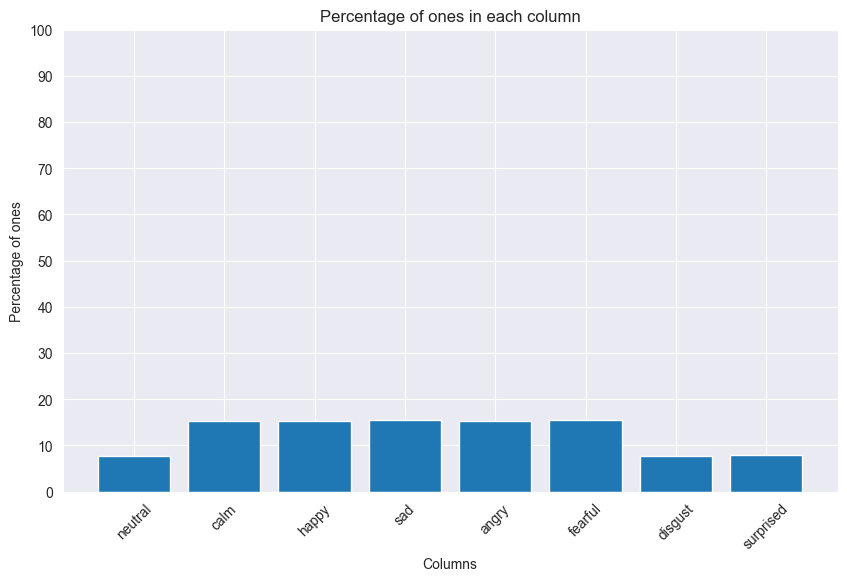

In [7]:
plot_percentage(df, emotions)

## Visualize the target emotion

In [8]:
TARGET_EMOTION = 'disgust'

In [9]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler

def isomap_by_emotion(data, emotions_list, emotion):

    data2 = data.drop(emotions_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    isomap = Isomap(n_components=2)
    embedding = isomap.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[emotion], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {emotion} attribute using Isomap')
    plt.show()

In [10]:
from sklearn.decomposition import PCA

def pca_by_emotion(data, emotions_list, emotion):

    data2 = data.drop(emotions_list, axis=1)
    X_scaled = MinMaxScaler().fit_transform(data2)

    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X_scaled)

    plt.figure(figsize=(8, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=data[emotion], cmap='viridis')
    plt.xlabel('First component')
    plt.ylabel('Second component')
    plt.title(f'Scatterplot of {emotion} attribute using PCA')
    plt.show()

In [11]:
numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]

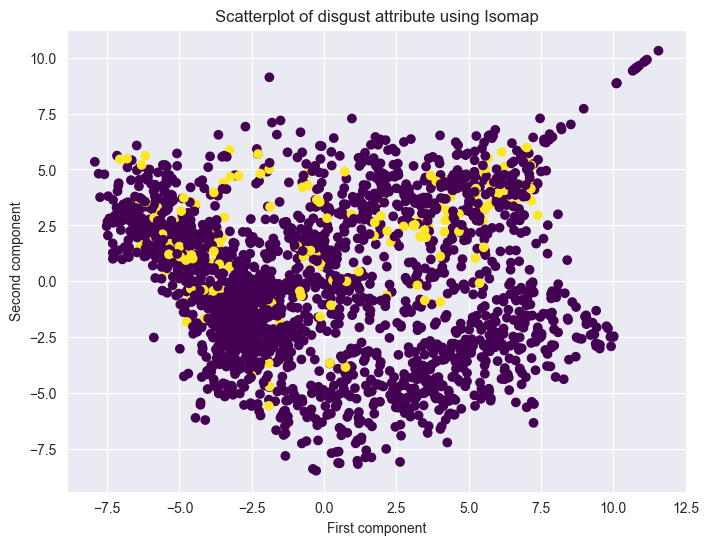

In [12]:
isomap_by_emotion(df[numerical_attr_list], emotions, TARGET_EMOTION)

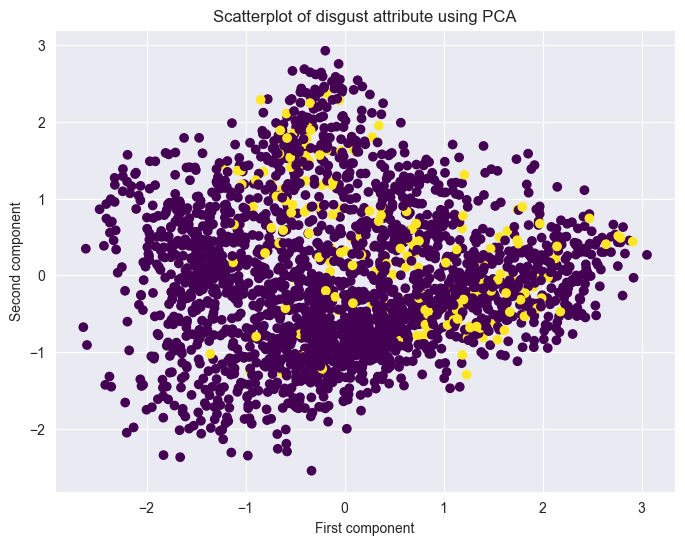

In [13]:
pca_by_emotion(df[numerical_attr_list], emotions, TARGET_EMOTION)

# Dataset preparation

In [14]:
excluded_prefixes = ['sc', 'stft', 'mfcc', 'zc']
columns_to_keep = []

for column in df[numerical_attr_list].drop(emotions, axis=1).columns:
    if not column.startswith(tuple(excluded_prefixes)):
        columns_to_keep.append(column)

columns_to_keep

['frame_count',
 'sum',
 'mean',
 'std',
 'min',
 'max',
 'q01',
 'q05',
 'q25',
 'q75',
 'q95',
 'q99',
 'kur',
 'skew',
 'lag1_std',
 'lag1_min',
 'lag1_max',
 'lag1_q01',
 'lag1_q05',
 'lag1_q25',
 'lag1_q75',
 'lag1_q95',
 'lag1_q99',
 'lag1_kur',
 'lag1_skew',
 'length_w1',
 'sum_w1',
 'std_w1',
 'q05_w1',
 'kur_w1',
 'skew_w1',
 'lag1_mean_w1',
 'lag1_max_w1',
 'lag1_q95_w1',
 'lag1_kur_w1',
 'lag1_skew_w1',
 'length_w2',
 'mean_w2',
 'std_w2',
 'min_w2',
 'q05_w2',
 'q50_w2',
 'q95_w2',
 'kur_w2',
 'skew_w2',
 'lag1_sum_w2',
 'lag1_kur_w2',
 'lag1_skew_w2',
 'length_w3',
 'mean_w3',
 'std_w3',
 'q50_w3',
 'q99_w3',
 'kur_w3',
 'skew_w3',
 'lag1_sum_w3',
 'lag1_min_w3',
 'lag1_q50_w3',
 'lag1_kur_w3',
 'lag1_skew_w3',
 'length_w4',
 'sum_w4',
 'q01_w4',
 'q75_w4',
 'kur_w4',
 'skew_w4',
 'lag1_sum_w4',
 'lag1_std_w4',
 'lag1_q05_w4',
 'lag1_kur_w4',
 'lag1_skew_w4']

In [15]:
df_clf = df.drop(df.columns.difference(columns_to_keep), axis=1)
target = df[TARGET_EMOTION]

In [16]:
split_index = df.index[df['actor'] == 'actor_19'][0]

df_train = df_clf[:split_index]
df_test = df_clf[split_index:]

target_train = target[:split_index]
target_test = target[split_index:]

display(df_train.shape, df_test.shape)

(1810, 71)

(619, 71)

In [17]:
numerical_attr_list = [col for col in df_clf.columns if is_numeric_dtype(df_clf[col])]

df_train = df_train[numerical_attr_list]
df_test = df_test[numerical_attr_list]

In [18]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(df_train)
X_test = scaler.fit_transform(df_test)

y_train = target_train.to_numpy()
y_test = target_test.to_numpy()

# Undersampling
## CNN

In [19]:
from collections import Counter
from imblearn.under_sampling import CondensedNearestNeighbour

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=-1)
X_res, y_res = cnn.fit_resample(X_train, y_train)

print(f'Starting dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_res)}')

Starting dataset shape Counter({False: 1668, True: 142})
Resampled dataset shape Counter({False: 288, True: 142})


In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
"""
param_grid = {
    'n_neighbors': np.arange(5, 100),
    'weights': ['distance'],
    'metric': ['euclidean', 'minkowski', 'cityblock'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_res, y_res)
clf = grid.best_estimator_
print(grid.best_params_, grid.best_score_)"""

# printed {'metric': 'cityblock', 'n_neighbors': 57, 'weights': 'distance'}
clf = KNeighborsClassifier(n_neighbors=57, metric='cityblock', weights='distance')
clf.fit(X_res, y_res)

KNeighborsClassifier(metric='cityblock', n_neighbors=57, weights='distance')

In [21]:
clf.score(X_test, y_test)

0.9176090468497576

In [22]:
from sklearn.metrics import classification_report

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       572
        True       0.25      0.04      0.07        47

    accuracy                           0.92       619
   macro avg       0.59      0.52      0.51       619
weighted avg       0.87      0.92      0.89       619



# Oversampling
## SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(f'Starting dataset shape {Counter(y_train)}')
print(f'Resampled dataset shape {Counter(y_res)}')

Starting dataset shape Counter({False: 1668, True: 142})
Resampled dataset shape Counter({False: 1668, True: 1668})


In [24]:
"""
param_grid = {
    'n_neighbors': np.arange(5, 100),
    'weights': ['distance'],
    'metric': ['euclidean', 'minkowski', 'cityblock'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_res, y_res)
clf = grid.best_estimator_
print(grid.best_params_, grid.best_score_)"""

# printed {'metric': 'cityblock', 'n_neighbors': 6, 'weights': 'distance'}
clf = KNeighborsClassifier(n_neighbors=6, metric='cityblock', weights='distance')
clf.fit(X_res, y_res)

KNeighborsClassifier(metric='cityblock', n_neighbors=6, weights='distance')

In [25]:
clf.score(X_test, y_test)

0.827140549273021

In [26]:
y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.95      0.85      0.90       572
        True       0.22      0.49      0.30        47

    accuracy                           0.83       619
   macro avg       0.59      0.67      0.60       619
weighted avg       0.90      0.83      0.86       619

